# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Setup: Import Packages and FMA Data

In [5]:
%matplotlib inline

import os
from pathlib import Path

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

import utils.fma_extraction as fma_utils
import utils.ml_training as ml_utils

plt.rcParams["figure.figsize"] = (17, 5)

In [6]:
# Directory where mp3 are stored.
FMA_METADATA_DIRECTORY = os.getenv("FMA_METADATA_DIRECTORY")
FMA_AUDIO_DIRECTORY = os.getenv("FMA_AUDIO_DIRECTORY")

# Load metadata and features.
tracks = fma_utils.load(Path(FMA_METADATA_DIRECTORY) / "tracks.csv")
genres = fma_utils.load(Path(FMA_METADATA_DIRECTORY) / "genres.csv")
features = fma_utils.load(Path(FMA_METADATA_DIRECTORY) / "features.csv")
echonest = fma_utils.load(Path(FMA_METADATA_DIRECTORY) / "echonest.csv")

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()  # noqa: S101

# Merge features with echonest.
features.merge(echonest, left_index=True, right_index=True, how="left")

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

## Echonest features

In [14]:
print("{1} features for {0} tracks".format(*echonest.shape))
ipd.display(echonest["echonest", "audio_features"].head())
print("Audio features include", echonest["echonest", "audio_features"].columns)

249 features for 13129 tracks


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


Audio features include Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')


,000,001,002,003,004,005,006,007,008,009,...,214,215,216,217,218,219,220,221,222,223
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
10,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
134,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,0.428946,0.446736,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


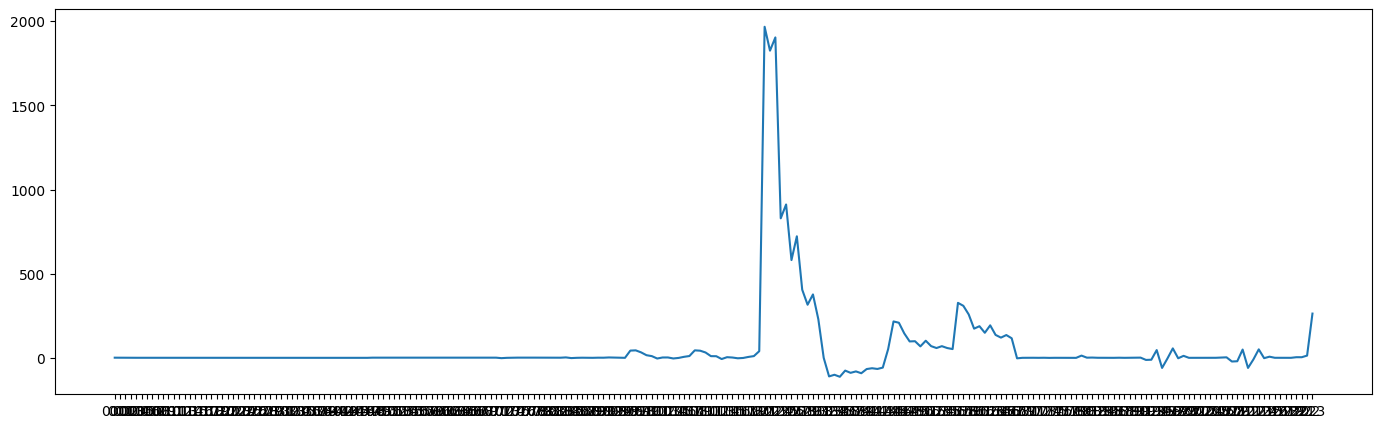

In [11]:
ipd.display(echonest["echonest", "temporal_features"].head())
x = echonest.loc[2, ("echonest", "temporal_features")]
plt.plot(x)

## Classification by Features

In [ ]:
medium = (tracks["set", "subset"] <= "medium")  # Filters for rows where the subset is "medium"

# Create a boolean mask for the training, validation, and test data (where "set" is "training/validation/test")
train = tracks["set", "split"] == "training"
val = tracks["set", "split"] == "validation"
test = tracks["set", "split"] == "test"

# Select the genre labels (target) and feature values for the training set
y_train = tracks.loc[medium & train, ("track", "genre_top")]
y_test = tracks.loc[medium & test, ("track", "genre_top")]
X_train = features.loc[medium & train, ml_utils.feature_columns].values
X_test = features.loc[medium & test, ml_utils.feature_columns].values

# Flatten the feature arrays if needed (if features are multidimensional, e.g., MFCC)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(f"{y_train.size} training examples, {y_test.size} testing examples")
print(f"{X_train.shape[1]} features, {np.unique(y_train).size} classes")

19922 training examples, 2573 testing examples
518 features, 16 classes


In [8]:
# Specify feature reduction and classifier
reduce_features = False
model_classifer = "SVM"

# Preprocess data, removing features if specified
X_train, X_test, y_train_encoded, y_test_encoded = ml_utils.preprocess_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    reduce_features=reduce_features)

# Train, evaluate, and retrieve the specified model
clf, score = ml_utils.train_and_evaluate(
    X_train=X_train,
    y_train_encoded=y_train_encoded,
    X_test=X_test,
    y_test_encoded=y_test_encoded,
    model_classifier=model_classifer,
)


Accuracy: 62.88%
